In [1]:
# IMPORT PACKAGES

import pandas as pd
from pandas import json_normalize
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import numpy as np
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
from adjustText import adjust_text
import matplotlib.patches as mpatches
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# SET SEASON, MATCH and TEAM
competition_id = 12
season_id = 27
match_id = 3879799
asroma = "AS Roma"

In [3]:
# FULL TIME SCORE

matches = requests.get("https://raw.githubusercontent.com/statsbomb/open-data/refs/heads/master/data/matches/"+str(competition_id)+"/"+str(season_id)+".json")
matches = matches.json()

for match in matches:
    if match['match_id'] == match_id:
        print(match['home_team']['home_team_name'],"-", match['away_team']['away_team_name'],
          str(match['home_score']) , ":" , str(match['away_score']) , "(match_id: " , str(match['match_id']) , ")")

Lazio - AS Roma 1 : 4 (match_id:  3879799 )


In [4]:
# SHOW FORMATION & GET SHOTS AND PASSES
events = requests.get("https://raw.githubusercontent.com/statsbomb/open-data/refs/heads/master/data/events/"+str(match_id)+".json")
events = events.json()
match_events = json_normalize(events, sep="_")
pd.set_option("display.max.columns",None)

# esaminiamo i tiri
asroma_shots = match_events.loc[(match_events["type_name"] == "Shot") & (match_events["team_name"] == asroma)]

#passaggi
asroma_passes = match_events.loc[(match_events["type_name"] == "Pass") & (match_events["team_name"] == asroma)].loc[match_events["pass_type_name"] != "Throw-in"]

formazione = match_events.loc[:,"team_name":"tactics_formation"]
formazione = formazione[(formazione["team_name"] == asroma) & formazione["tactics_formation"].notna()]
modulo = "-".join(str(int(formazione.iloc[0,1])))
modulo

'4-4-1-1'

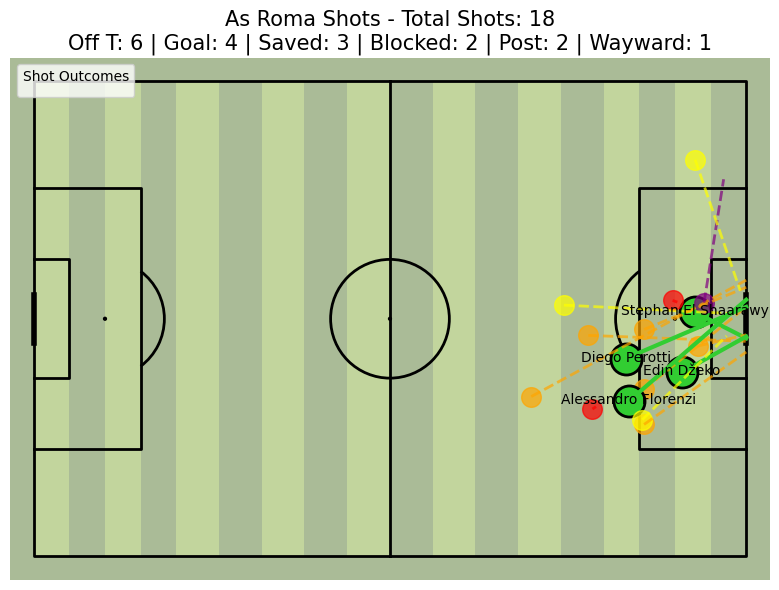

In [5]:
# SHOW ALL SHOTS

total_shots = len(asroma_shots)  # Totale tiri
goals = len(asroma_shots[asroma_shots["shot_outcome_name"] == "Goal"])  # Gol fatti

# numero di tiri per ogni tipo di outcome
outcome_counts = asroma_shots["shot_outcome_name"].value_counts()

# grafico
fig, ax = plt.subplots(figsize=(12, 6))
pitch = Pitch(line_color="black", pitch_color="#aabb97", stripe_color="#c2d59d"
              , stripe=True, pitch_length=100, pitch_width=70)  # campo metà e verticale
pitch.draw(ax=ax)

# colori per ogni tipo di tiro sbagliato (outcome)
missed_outcomes_colors = { "Blocked": "red",  "Off T": "orange",  "Wayward": "purple",  "Saved": "yellow",  "Saved to Post": "blue", "Saved Off Target":"pink"}

# creare una lista per le etichette della legenda
legend_labels = []
legend_lines = []

# disegnare i tiri
for x in range(len(asroma_shots["id"])):
    outcome = asroma_shots["shot_outcome_name"].iloc[x]
    if outcome == "Goal":

        # linea verde
        line = plt.plot(   (asroma_shots["location"].iloc[x][0], asroma_shots["shot_end_location"].iloc[x][0]), # coordinata x
                            (asroma_shots["location"].iloc[x][1], asroma_shots["shot_end_location"].iloc[x][1]), # coordinata y
                            color="limegreen", linestyle="-", linewidth=3)
        
        # cerchio più grande e luminoso per i gol
        plt.scatter(asroma_shots["location"].iloc[x][0], asroma_shots["location"].iloc[x][1], color="limegreen", s=500, edgecolors="black", linewidth=2)

        # aggiungi il nome del giocatore che ha segnato
        player_name = asroma_shots["player_name"].iloc[x]
        plt.text(asroma_shots["location"].iloc[x][0], asroma_shots["location"].iloc[x][1]+0.5,  # posizione del testo
                 player_name, color="black", fontsize=10, ha="center")

    elif outcome in missed_outcomes_colors:
        # prendo il colore assegnato
        color = missed_outcomes_colors[outcome]
        line = plt.plot(   (asroma_shots["location"].iloc[x][0], asroma_shots["shot_end_location"].iloc[x][0]),
                            (asroma_shots["location"].iloc[x][1], asroma_shots["shot_end_location"].iloc[x][1]),
                            color=color, linestyle="--", linewidth=2, alpha=0.7)
        
        plt.scatter(asroma_shots["location"].iloc[x][0], asroma_shots["location"].iloc[x][1], color=color, s=200, alpha=0.7)

    # aggiungo il tiro alla legenda
    if outcome not in legend_labels:
        legend_labels.append(outcome)
        legend_lines.append(line)

# titolo
outcome_title = " | ".join([f"{outcome}: {count}" for outcome, count in outcome_counts.items()])
plt.title(f"As Roma Shots - Total Shots: {total_shots}\n{outcome_title}", size=15)

plt.legend(legend_lines, legend_labels, loc="upper left", fontsize=10, title="Shot Outcomes")
plt.tight_layout()
plt.show()


In [6]:
# EVENTS BEFORE GOALS

# eventi della Roma
roma_events = match_events[match_events["team_name"] == asroma]
goal_events = roma_events[roma_events["shot_outcome_name"] == "Goal"]

# dizionario per raccogliere gli eventi precedenti a ciascun gol
events_before_goals_dict = {}

# per ogni gol trovato seleziona gli eventi precedenti
for goal, row in goal_events.iterrows():

    # eventi precedenti al gol
    events_before_goal = roma_events[roma_events.index <= goal]
    
    # ultimi 5 eventi
    last_5_events = events_before_goal.tail(5)
    events_before_goals_dict[goal] = last_5_events

for key,value in events_before_goals_dict.items():
    print(key,value["type_name"])


690 686    Ball Receipt*
687            Carry
688             Pass
689    Ball Receipt*
690             Shot
Name: type_name, dtype: object
2515 2509    Ball Receipt*
2510            Carry
2512             Shot
2514    Ball Recovery
2515             Shot
Name: type_name, dtype: object
3033 3025             Pass
3026    Ball Receipt*
3029             Pass
3032    Ball Recovery
3033             Shot
Name: type_name, dtype: object
3184 3176    Ball Receipt*
3177             Duel
3182             Duel
3183            Carry
3184             Shot
Name: type_name, dtype: object


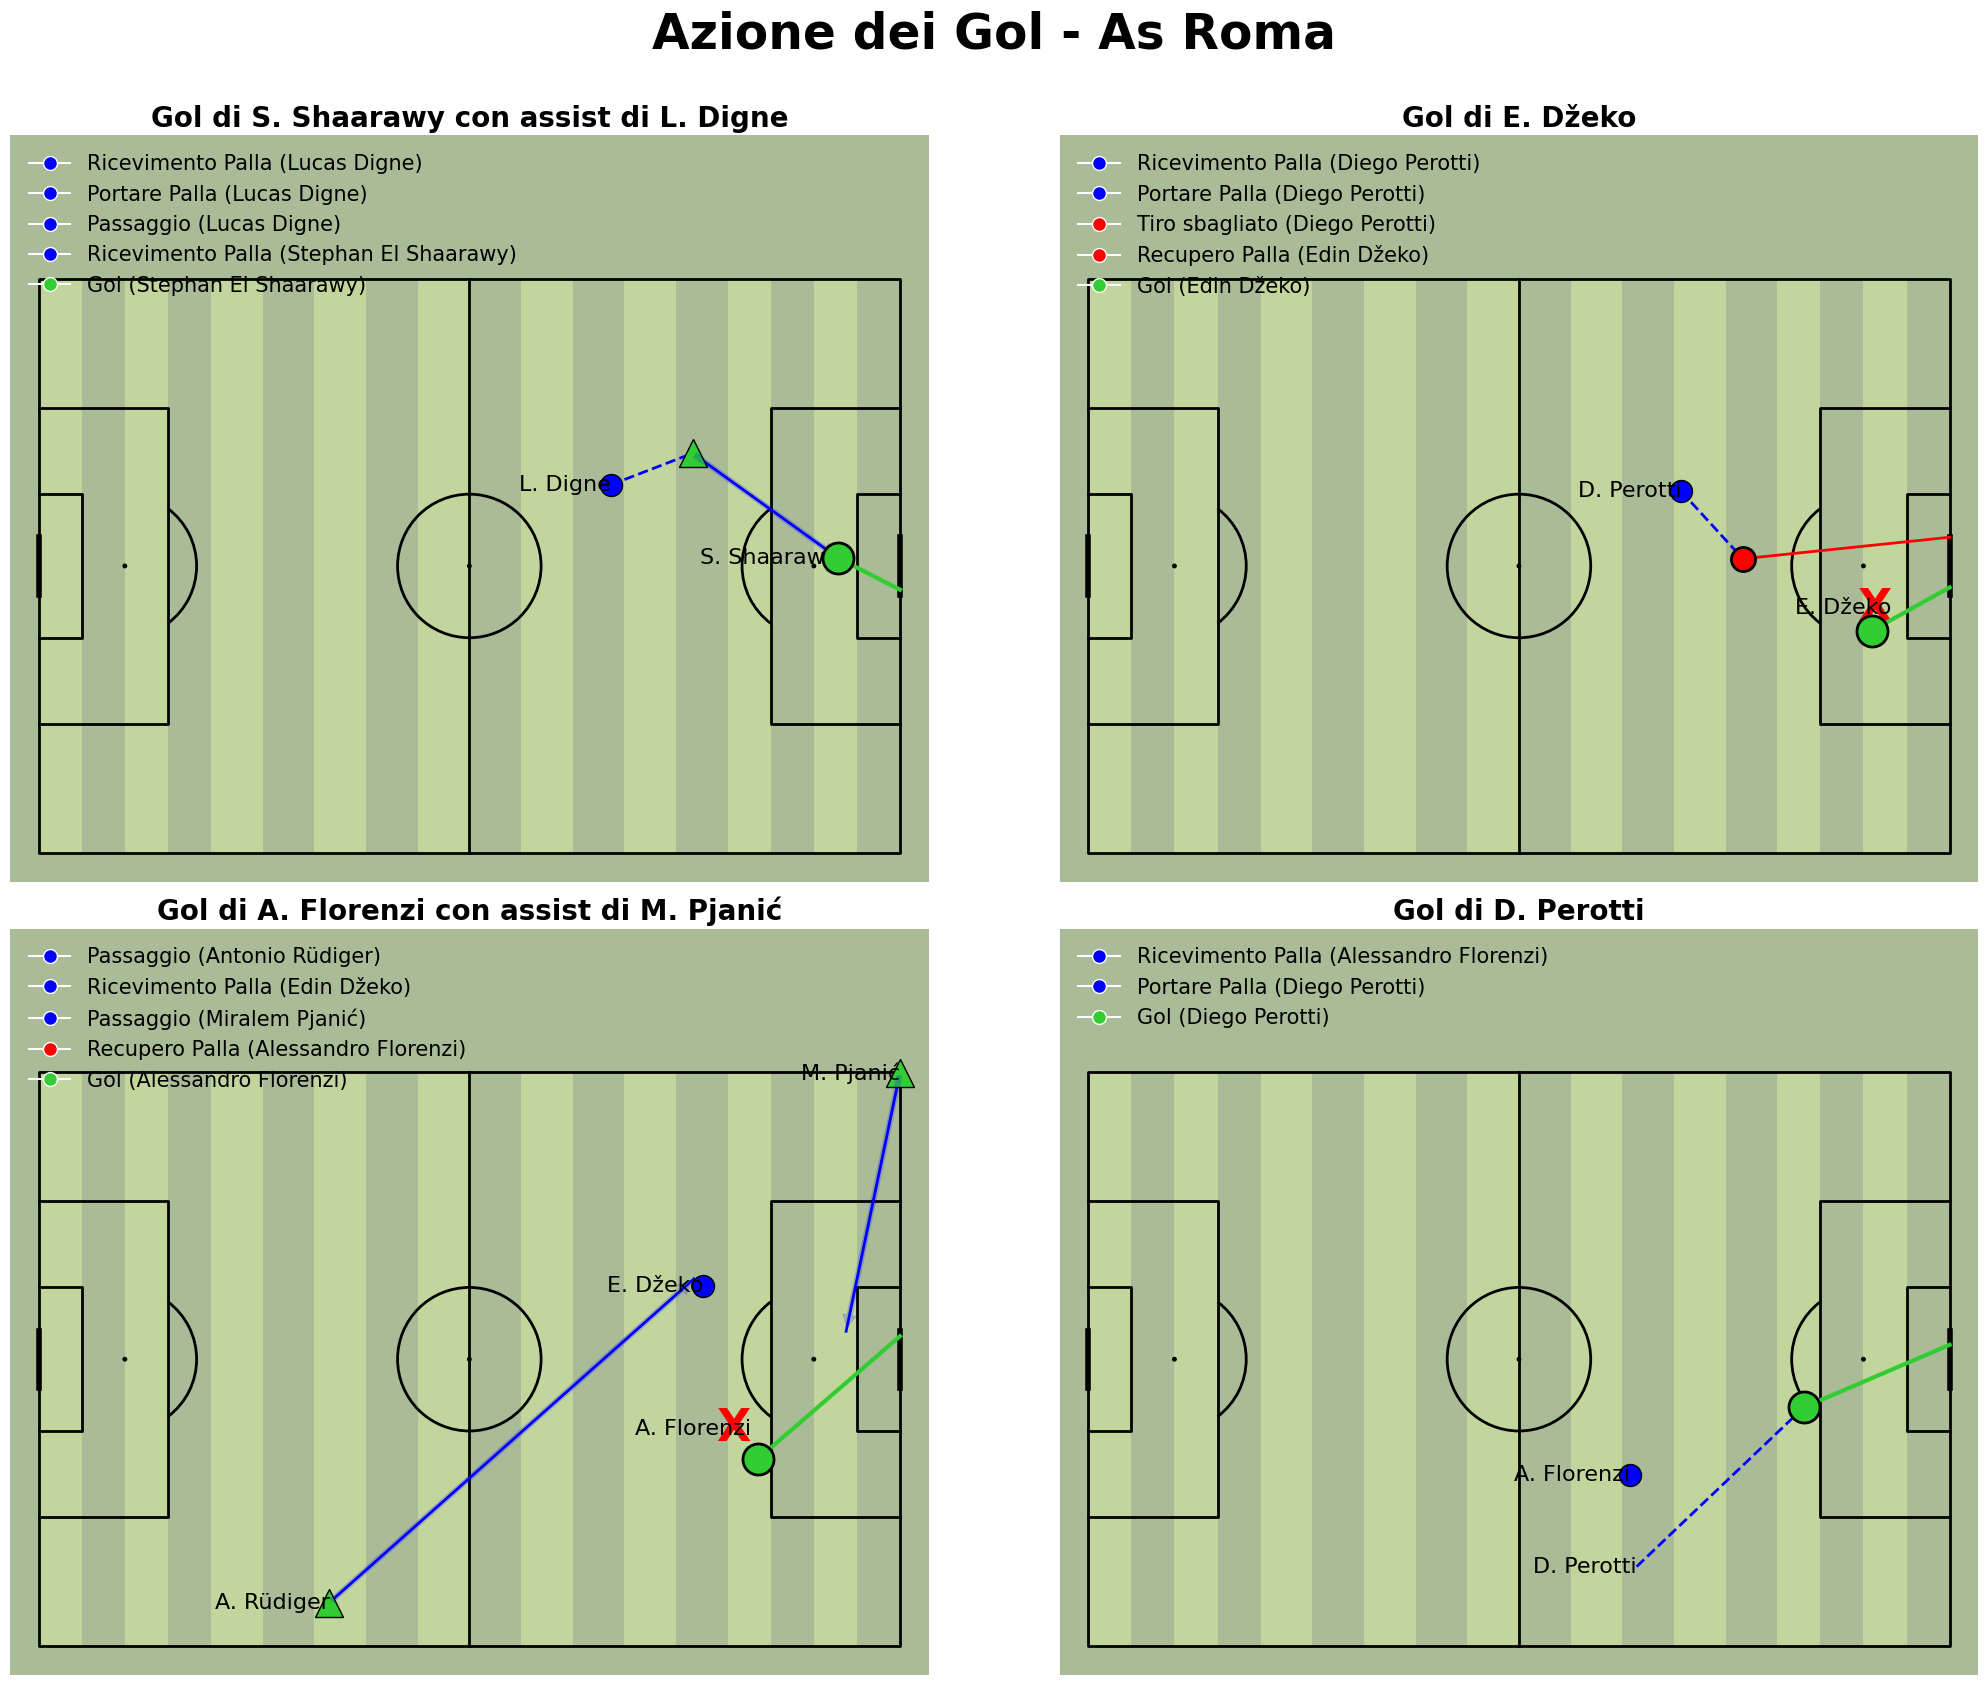

In [7]:
# SHOW GOAL EVENTS

# il numero di goal è la lunghezza del dizionario
num_goals = len(events_before_goals_dict)

if num_goals == 0:
    ncols = 2
    nrows = 1

else:
    # calcola il numero di righe e colonne dinamicamente in base al numero di gol
    ncols = 2  # 3 colonne fisse
    nrows = num_goals // ncols  # divisione intera per determinare quante righe intere ci sono
    if num_goals % ncols != 0:  # se ci sono gol rimanenti che non riempiono una riga
        nrows += 1  # aggiungi una riga per i gol rimanenti

fig, axs = plt.subplots(figsize=(22, 16), nrows=nrows, ncols=ncols)
axs = axs.flatten()  # facilita l'iterazione della matrice creata sopra

# elenco dei passaggi considerati "sbagliati"
invalid_pass_outcomes = ["Incomplete", "Out", "Unknown", "Pass Offside", "Injury Clearance"]

# indice della matrice
goal_counter = 0

# crea il grafico per ogni gol nel dizionario
for goal_event_index, events_before_goal in events_before_goals_dict.items():

    ax = axs[goal_counter]  # Ogni gol avrà una sottotrama separata

    # crea il campo da gioco
    pitch = Pitch(line_color="black", pitch_color="#aabb97", stripe_color="#c2d59d", half=False, stripe=True, pad_top=20, pitch_length=140, pitch_width=100)
    pitch.draw(ax=ax)

    # variabili per il nome del giocatore che ha segnato e per l'assist
    # None perchè la partita può finire senza gol e senza assist
    goal_scorer = None
    assist_provider = None

    # lista dei giocatori coinvolti negli eventi precedenti a questo gol
    # e variabile per tenere traccia del primo evento per ogni giocatore
    # se un giocatore effettua più eventi consecutivi, voglio visualizzare il suo nome solo all'inizio (primo evento)
    players = events_before_goal["player_name"].unique()
    first_event = {}

    # liste per raccogliere le etichette per la legenda
    legend_elements = []

    for player in players:
        player_events = events_before_goal[events_before_goal["player_name"] == player]

        for index, row in player_events.iterrows():
            if row['type_name'] not in ['Carry', 'Ball Recovery', 'Pass', 'Ball Receipt*', 'Shot', 'Foul Won']:
                continue 
            x = row["location"][0]
            y = row["location"][1]

            # nome del giocatore: primo carattere del nome + punto + cognome intero
            player_name_formatted = f"{row["player_name"].split()[0][0]}. {row["player_name"].split()[-1]}"
            
            # etichettiamo il giocatore solo al primo evento
            if player not in first_event:
                first_event[player] = True
                ax.text(x, y, f"{player_name_formatted}", fontsize=16, ha="right",va="center", color="black", zorder=4)

            # se l'evento è un "Ball Recovery", tracciamo una X rossa
            if row["type_name"] == "Ball Recovery":
                ax.text(x, y, "X", fontsize=32, ha="right", color="red", va="center", fontweight="bold", zorder=3)
                if ("Ball Recovery", player) not in legend_elements:
                    legend_elements.append(("Recupero Palla", player, "red"))

            # se l'evento è un "Ball Receipt", disegniamo un nodo blu per il ricevimento della palla
            if row["type_name"] == "Ball Receipt*":
                ax.scatter(x, y, color="blue", s=250, edgecolors="black", zorder=3)
                if ("Ball Receipt*", player) not in legend_elements:
                    legend_elements.append(("Ricevimento Palla", player, "blue"))
            
            # se l'evento è un "Carry", tracciamo una linea tratteggiata
            if row["type_name"] == "Carry":
                x_end, y_end = row["carry_end_location"]
                ax.plot([x, x_end], [y, y_end], color="blue", linestyle="--", lw=2, zorder=2)
                if ("Carry", player) not in legend_elements:
                    legend_elements.append(("Portare Palla", player, "blue"))

            # se l'evento è un "Pass", tracciamo una freccia usando FancyArrowPatch
            if row["type_name"] == "Pass":
                x_end, y_end = row["pass_end_location"]
                ax.plot([x, x_end], [y, y_end], color="blue", lw=2, zorder=2)#, alpha=0.4)
                arrow = FancyArrowPatch(    (x, y), (x_end, y_end), mutation_scale=20,  # scala della freccia
                                            color="blue", lw=0.2, alpha=0.2, zorder=4)
                ax.add_patch(arrow)
                
                # se il passaggio è stato un assist memorizzo il giocatore che ha effettuato l'assist
                if row.get("pass_goal_assist", False):
                    assist_provider = player_name_formatted
                    # disegnare il triangolo verde per l'assist
                    ax.plot(x, y, marker="^", markersize=20, color="limegreen", markeredgecolor="black", zorder=3)
                    
                if ("Passaggio", player) not in legend_elements:
                    legend_elements.append(("Passaggio", player, "blue"))
            
            # Se l'evento è un "Foul Won", disegniamo un quadrato arancione
            if row["type_name"] == "Foul Won":
                ax.scatter(x, y, color="orange", s=300, edgecolors="black", marker="s", zorder=3)
                if ("Foul Won", player) not in legend_elements:
                    legend_elements.append(("Foul Won", player, "orange"))

            #Se l'evento è un "Shot"
            if row["type_name"] == "Shot":
                # posizione finale del tiro
                x_end = row["shot_end_location"][0]
                y_end = row["shot_end_location"][1]

                # verifica se il tiro è stato un gol memorizza il nome del giocatore che ha segnato
                if row["shot_outcome_name"] == "Goal":
                    goal_scorer = player_name_formatted
                    ax.plot([x, x_end], [y, y_end], color="limegreen", linestyle="-", linewidth=3, zorder=3)
                    ax.scatter(x, y, color="limegreen", s=500, edgecolors='black', linewidth=2, zorder=4)

                    if ("Gol", player) not in legend_elements:
                        legend_elements.append(("Gol", player, "limegreen"))
                
                # tiro sbagliato altrimenti
                else:
                    ax.plot([x, x_end], [y, y_end], color="red", linestyle='-', linewidth=2, zorder=2)
                    ax.scatter(x, y, color="red", s=300, edgecolors='black', linewidth=2, zorder=3)
                    if ("Tiro sbagliato", player) not in legend_elements:
                        legend_elements.append(("Tiro sbagliato", player, "red"))

    # titolo
    title = f"Gol di {goal_scorer}"
    if assist_provider:
        title += f" con assist di {assist_provider}"
    ax.set_title(title, fontsize=20, fontweight="bold", color="black")

    # legenda
    handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10) for _, _, color in legend_elements]
    labels = [f"{evento} ({giocatore})" for evento, giocatore, _ in legend_elements]
    ax.legend(handles=handles, labels=labels, loc="upper left", fontsize=15, frameon=False)

    goal_counter += 1  # incremento indice subplots

# nascondi gli assi/subplots non utilizzati
for j in range(goal_counter, len(axs)):
    axs[j].axis("off")

# titolo all'intera figura
fig.text(0.5, 1.05, "Azione dei Gol - As Roma", ha="center", va="top", fontsize=35, fontweight="bold")
plt.tight_layout()
plt.show()


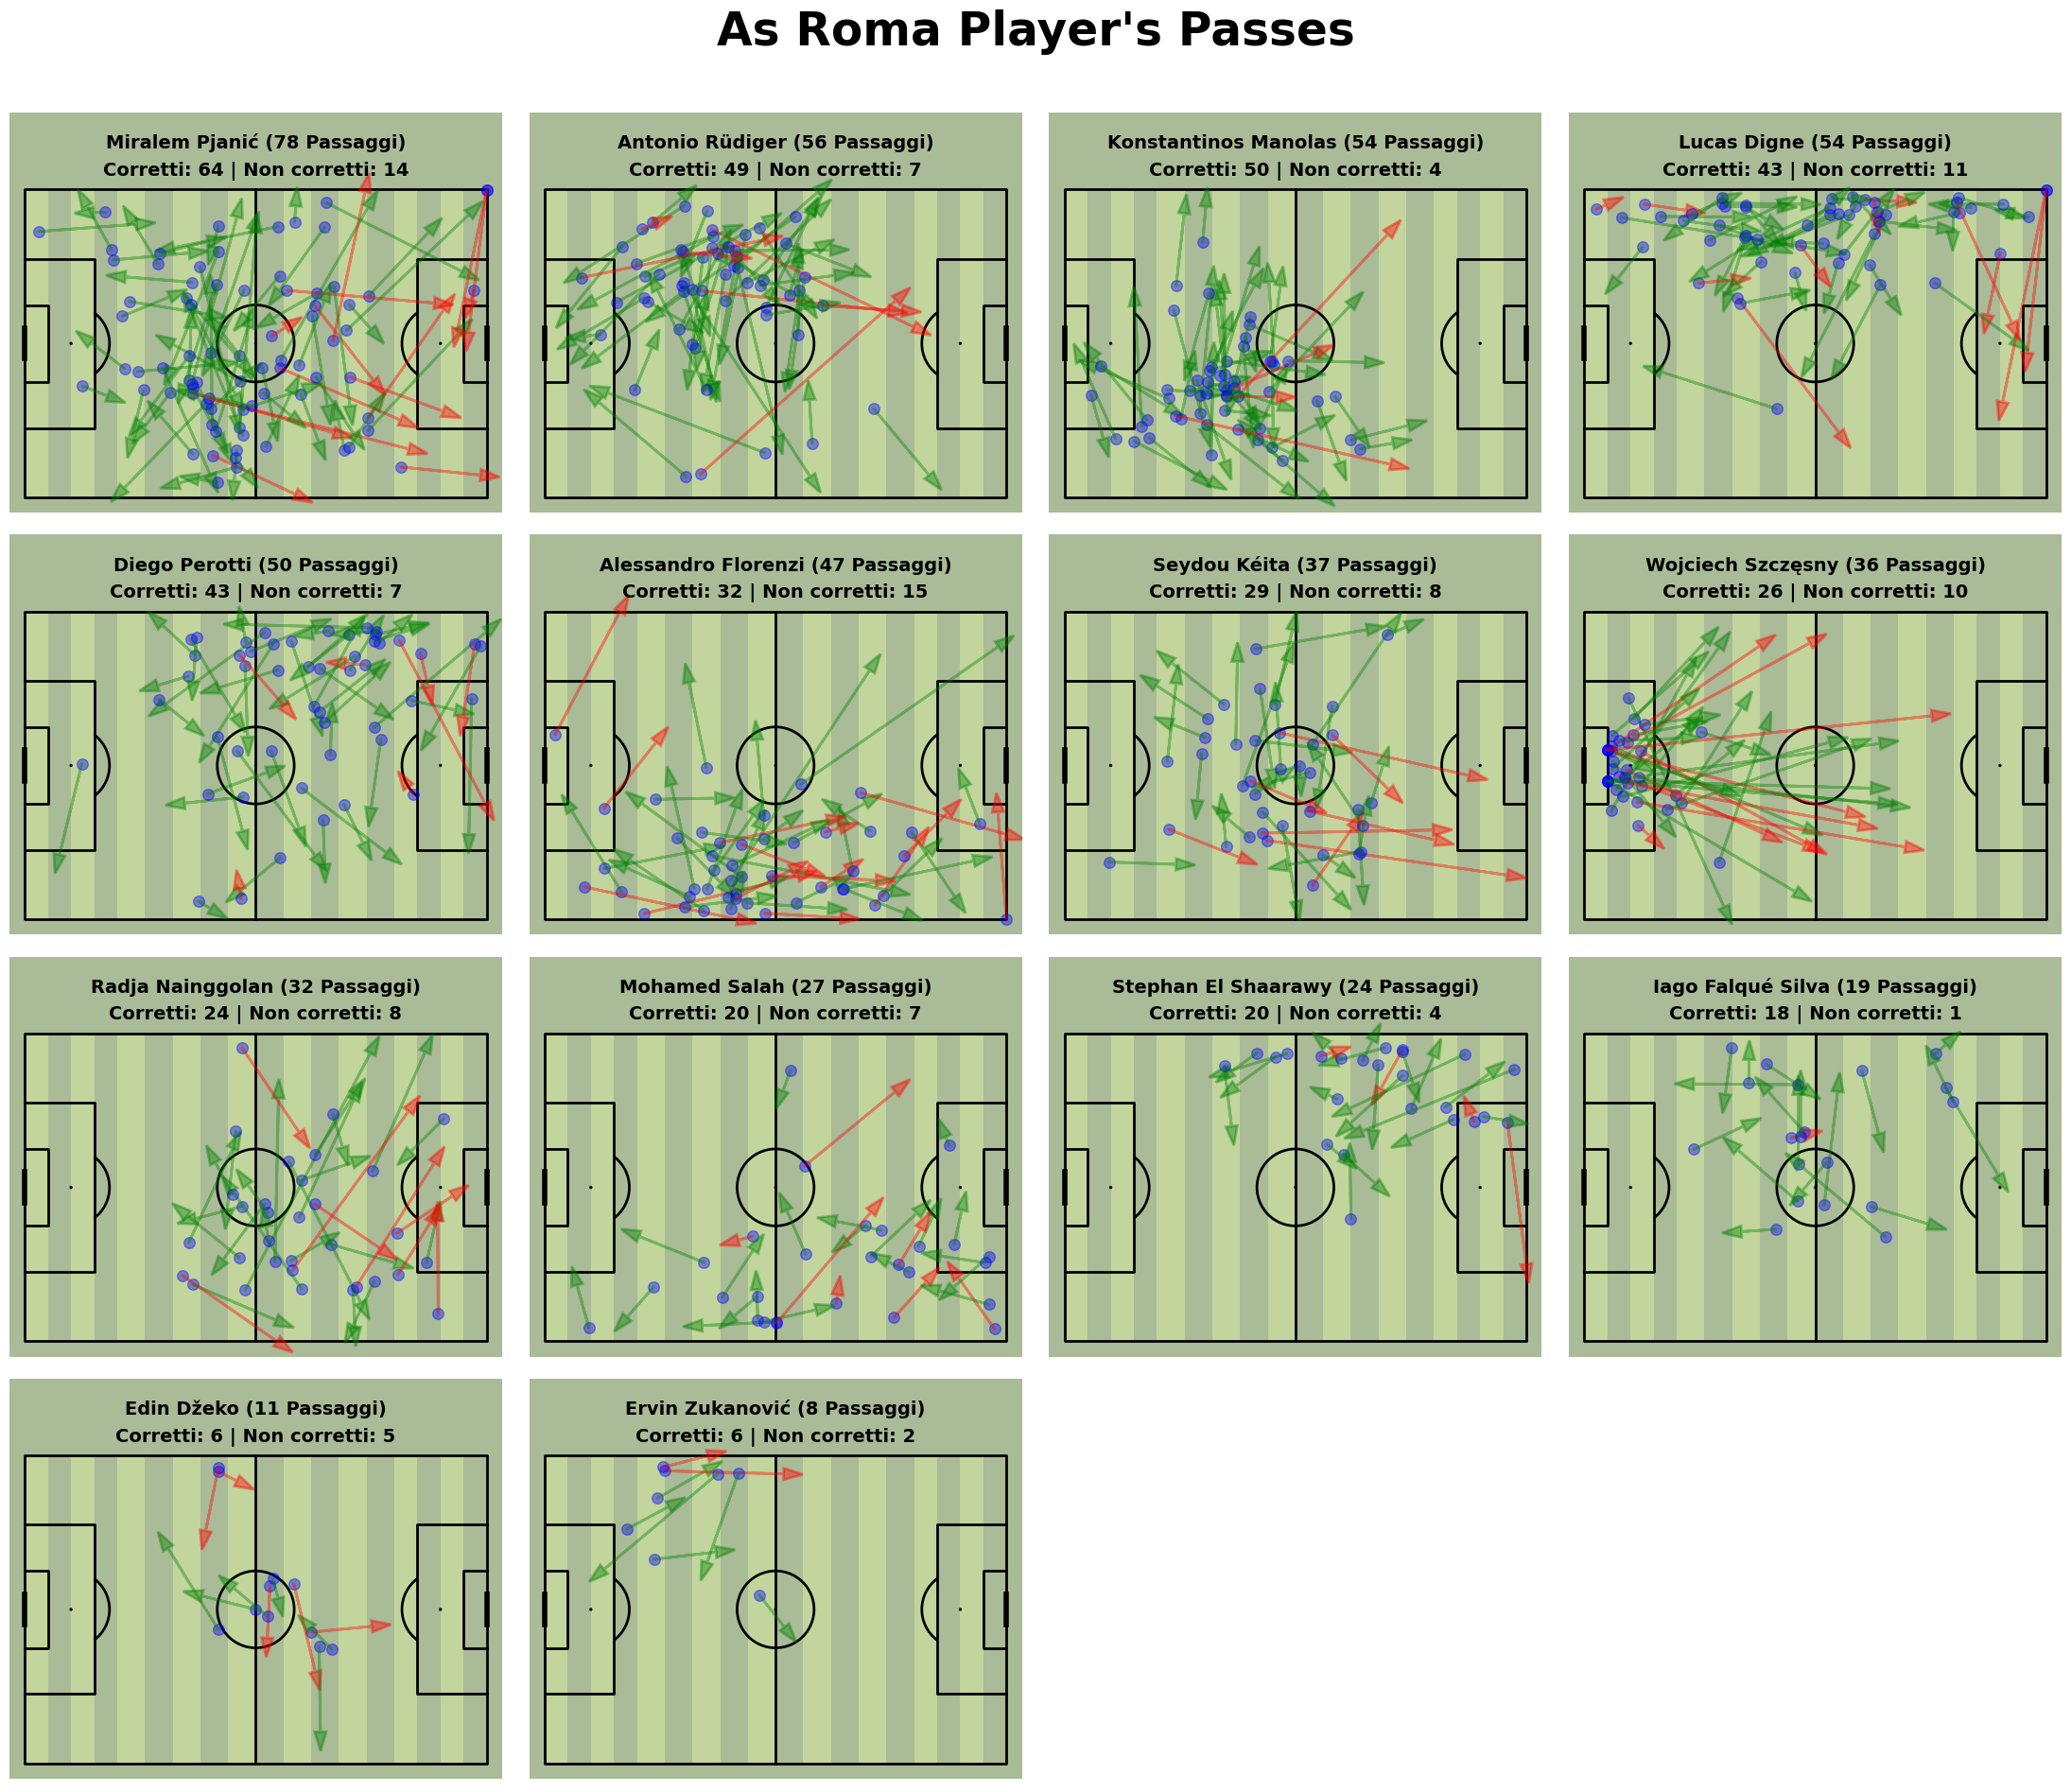

In [8]:
# SHOW ALL PASSES

# selezioniamo solo le colonne rilevanti
columns = asroma_passes.loc[:,["location","pass_end_location","player_name","pass_outcome_name"]]

# prendiamo la lista di tutti i giocatori che hanno effettuato un passaggio
# conta il numero di passaggi per ciascun giocatore
players = columns.groupby("player_name").size().sort_values(ascending=False).index.tolist()

# inizializzazione
fig, axs = plt.subplots(figsize=(22, 18), nrows=4, ncols=4)
axs = axs.flatten()

# passaggi considerati "sbagliati"
invalid_pass_outcomes = ["Incomplete", "Out", "Unknown", "Pass Offside", "Injury Clearance"]

# campo da gioco per ciascun giocatore
for i, player in enumerate(players):
    
    # disegna un Pitch all"axs[i]
    pitch = Pitch(line_color="black", pitch_color="#aabb97", stripe_color="#c2d59d", stripe=True, pad_top=20,pitch_length=140, pitch_width=100)
    ax = axs[i]
    pitch.draw(ax=ax)
    
    player_df = columns[columns["player_name"] == player]
    pass_count = len(player_df)

    # calcola il numero di passaggi corretti e non corretti
    correct_passes = len(player_df[~player_df["pass_outcome_name"].isin(invalid_pass_outcomes)])
    incorrect_passes = len(player_df[player_df["pass_outcome_name"].isin(invalid_pass_outcomes)])
    
    # titolo
    ax.text(0.5, 0.9, f"{player} ({pass_count} Passaggi)", color="black", fontsize=14, ha="center", va="bottom", 
            transform=ax.transAxes, fontweight="bold")
    
    # sottotilo
    ax.text(0.5, 0.83, f"Corretti: {correct_passes} | Non corretti: {incorrect_passes}", color="black", fontsize=14, ha="center", va="bottom", 
            transform=ax.transAxes, fontweight="bold")

    # estrazione coordinate e disegna le frecce
    for j in range(len(player_df)):
        x_start, y_start = player_df["location"].iloc[j][0], player_df["location"].iloc[j][1]
        x_end, y_end = player_df["pass_end_location"].iloc[j][0], player_df["pass_end_location"].iloc[j][1]
        
        # imposta il colore della freccia in base all"esito del passaggio
        if player_df["pass_outcome_name"].iloc[j] in invalid_pass_outcomes:
            arrow_color = "red"  # Passaggio sbagliato
        else:
            arrow_color = "green"  # Passaggio corretto
        
        # aggiungi uno scatter per le posizioni di partenza e di arrivo dei passaggi
        ax.scatter(x_start, y_start, color="blue", alpha=0.4, s=70)
        
        # Aggiungi le frecce per ogni passaggio usando ax.arrow()
        ax.arrow(
            x_start, y_start,  # coordinate di partenza
            x_end - x_start,   # componente x della freccia (differenza x)
            y_end - y_start,   # componente y della freccia (differenza y)
            head_width=3,      # larghezza della testa della freccia
            head_length=5,     # lunghezza della testa della freccia
            fc=arrow_color,        # colore della freccia
            ec=arrow_color,        # colore del bordo della freccia
            lw=2,
            alpha=0.4)

for j in range(len(players), len(axs)):
    axs[j].axis("off")

fig.text(0.5, 1.05, "As Roma Player's Passes", ha="center", va="top", fontsize=35, fontweight="bold")
plt.tight_layout()
plt.show()   



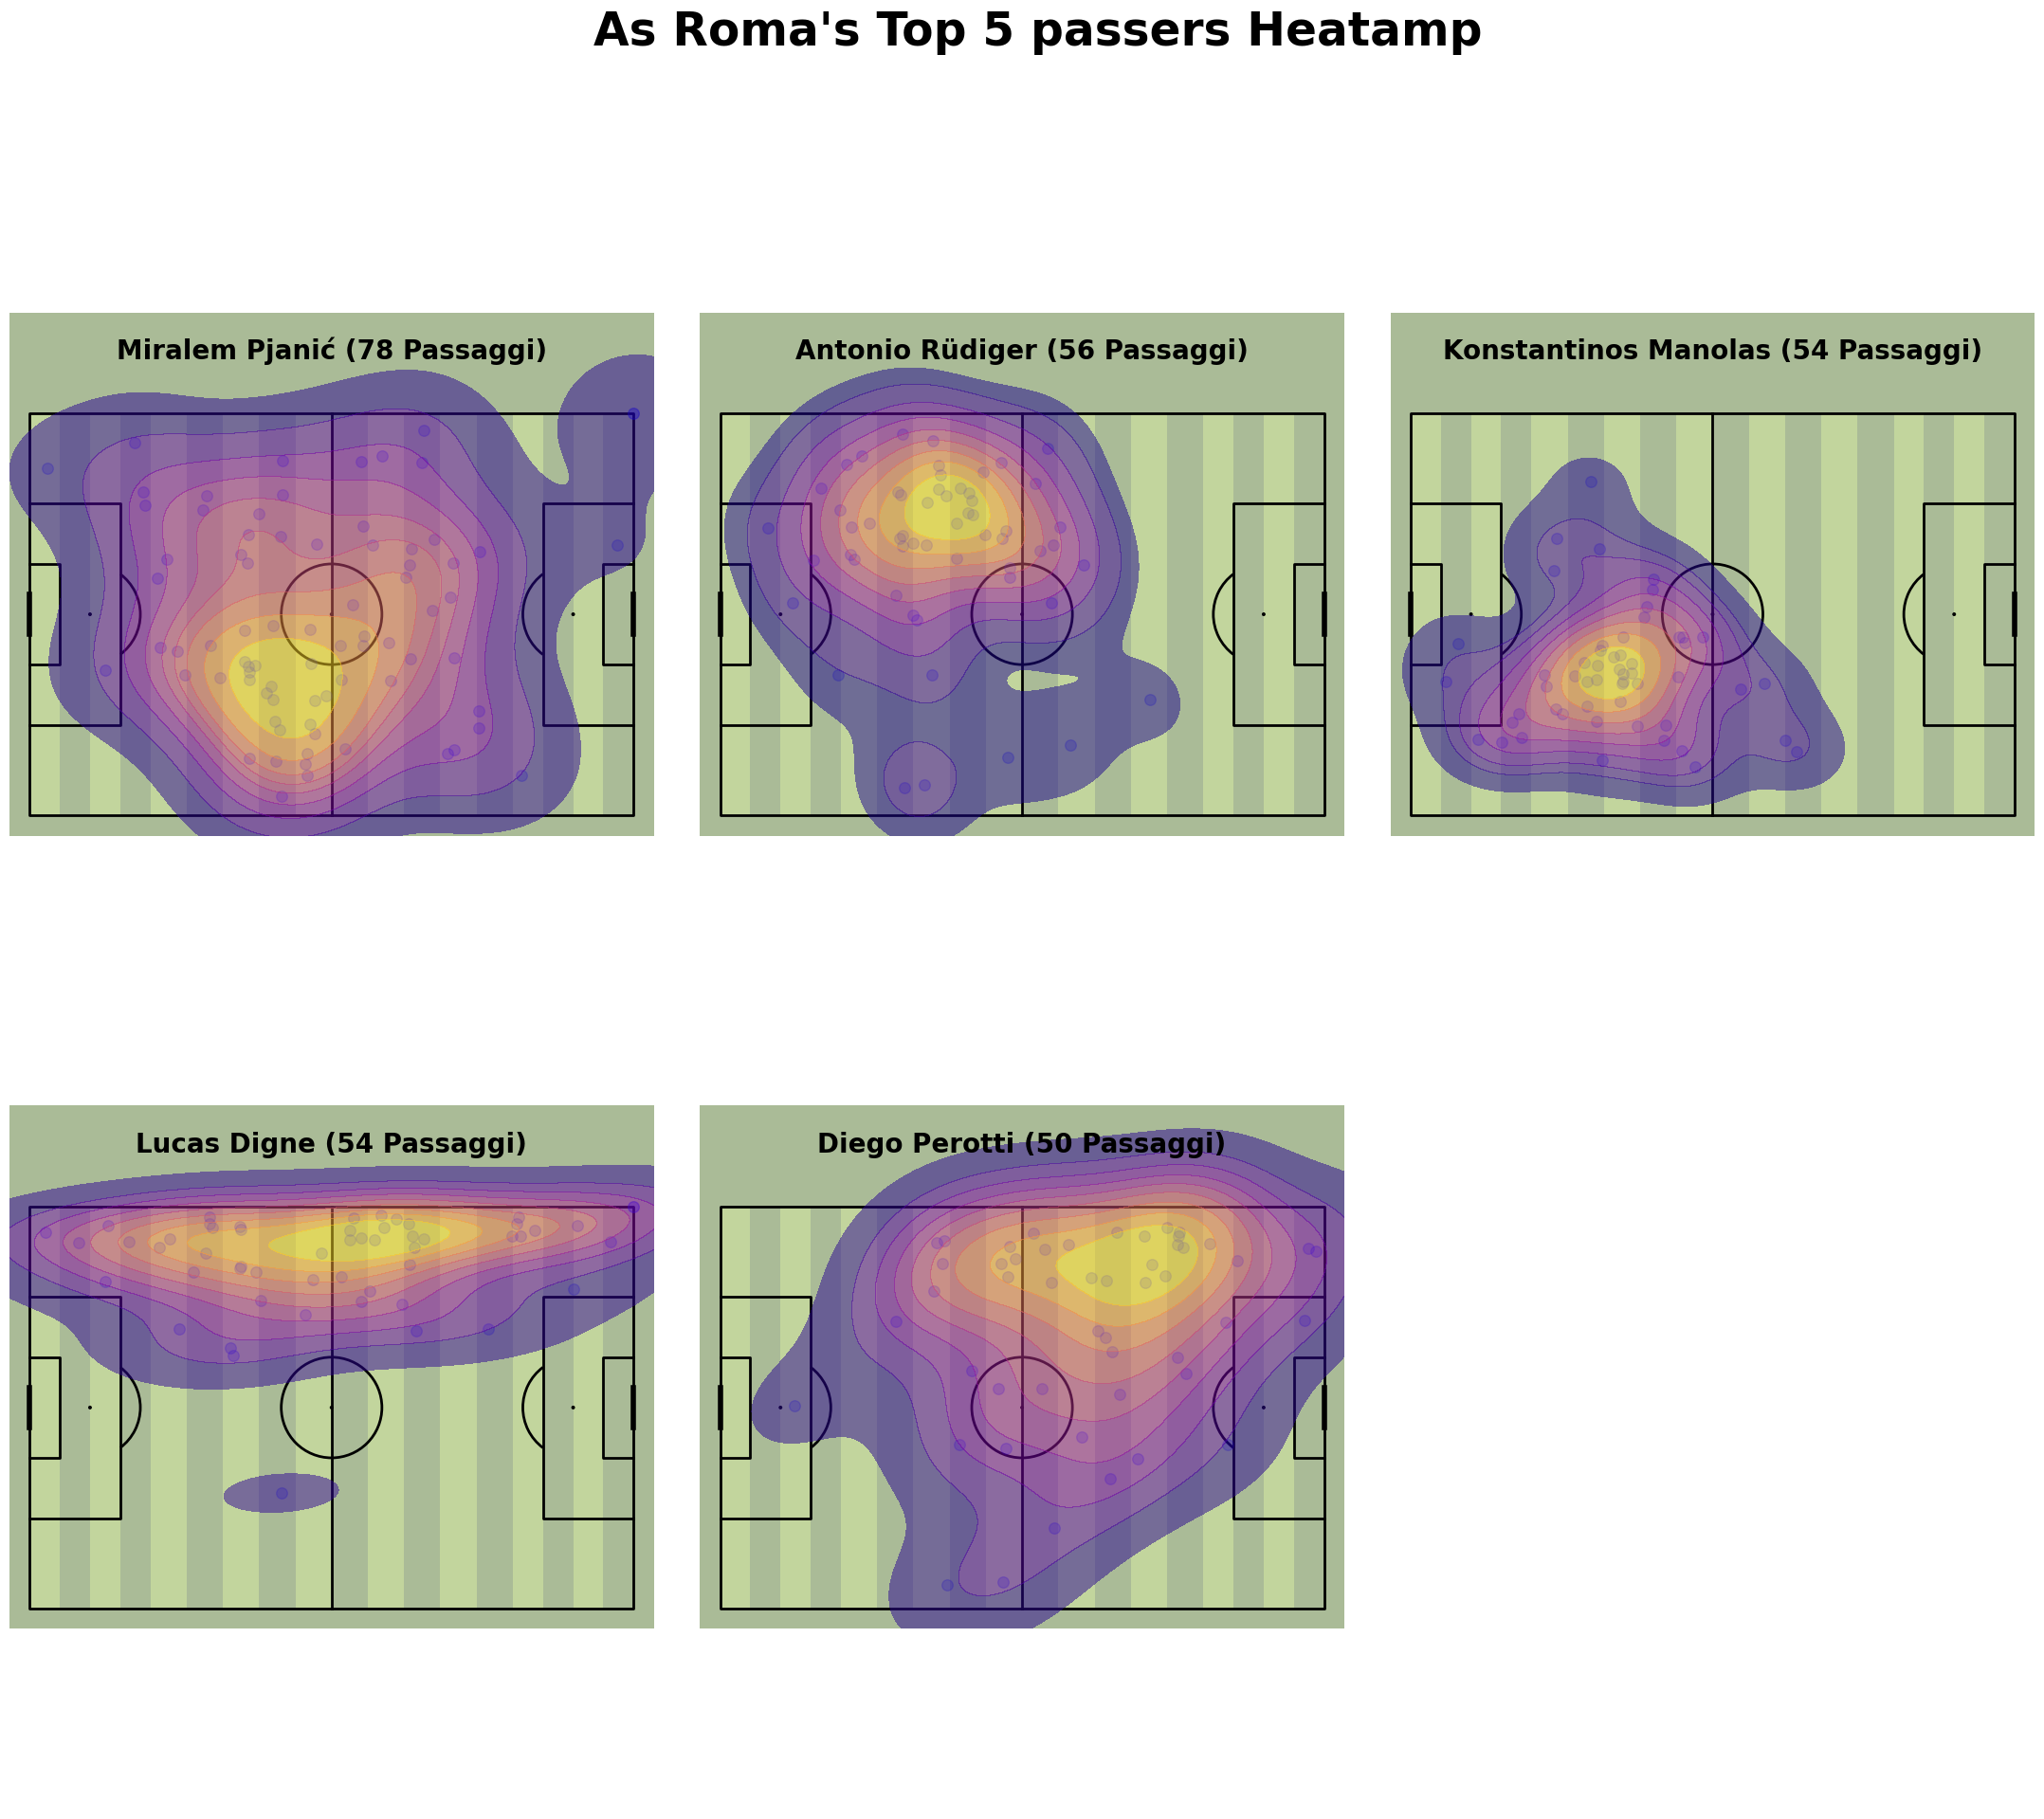

In [9]:
# SHOW TOP 5 PLAYERS - HEATMAP PASSES
top = 5 #scegliere la top " " giocatori
top_passers = players[:top]

fig, axs = plt.subplots(figsize=(22, 18), nrows=2, ncols=3)
axs = axs.flatten()

# disegna Pitch e KDE per ogni giocatore
for i, player in enumerate(top_passers):
    ax = axs[i]
    pitch = Pitch(line_color="black", pitch_color="#aabb97", stripe_color="#c2d59d", stripe=True, pad_top=20, pitch_length=140, pitch_width=100)
    pitch.draw(ax=ax)
    
    player_df = columns[columns["player_name"] == player]
    x_start = player_df["location"].apply(lambda x: x[0])
    y_start = player_df["location"].apply(lambda x: x[1])
    pass_count = len(player_df)
    
    ax.text(0.5, 0.9, f"{player} ({pass_count} Passaggi)", ha="center", va="bottom", transform=ax.transAxes, fontsize=20, fontweight="bold")
    ax.scatter(x_start, y_start, color="blue", alpha=0.2, s=70)
    # aggiungi un kdeplot per le posizioni di partenza
    sns.kdeplot(x=x_start, y=y_start, ax=ax, cmap="plasma", fill=True, alpha=0.5)

for j in range(len(top_passers), len(axs)):
    axs[j].axis("off")

fig.text(0.5, 1.05, "As Roma's Top 5 passers Heatamp", ha="center", va="center", fontsize=35, fontweight="bold")
plt.tight_layout()
plt.show()

In [10]:
# SHOW PASSING NETWORK

titolari = [player["player"]["name"] for player in match_events[match_events["team_name"] == asroma].iloc[0]["tactics_lineup"]]

# selezioniamo solo le colonne rilevanti
columns = asroma_passes.loc[:,["location","pass_end_location","player_name","pass_outcome_name","pass_recipient_name"]]
# colonna "is_starter" per verificare se il giocatore è titolare
columns['is_starter'] = columns['player_name'].apply(lambda x: x in titolari)

# creazione di un dataframe per il grafico dei passaggi
scatter_df = pd.DataFrame()

for i, name in enumerate(columns["player_name"].unique()):

    # estrazione di tutte le coordinate dei passaggi e delle ricezioni del giocatore
    passx = columns.loc[columns["player_name"] == name]["location"].apply(lambda x: x[0]).to_numpy()
    recx = columns.loc[columns["pass_recipient_name"] == name]["pass_end_location"].apply(lambda x: x[0]).to_numpy()
    passy = columns.loc[columns["player_name"] == name]["location"].apply(lambda y: y[1]).to_numpy()
    recy = columns.loc[columns["pass_recipient_name"] == name]["pass_end_location"].apply(lambda y: y[1]).to_numpy()
    
    scatter_df.at[i, "player_name"] = name

    # calcola la posizione media (media sia per i passaggi che per le ricezioni)
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    # calcola il numero di passaggi per ogni giocatore
    scatter_df.at[i, "no"] = columns.loc[columns["player_name"] == name].count().iloc[0]

    # aggiungi una colonna per segnare se il giocatore è titolare
    scatter_df.at[i, "is_starter"] = name in titolari

# regola la dimensione del cerchio in base al numero di passaggi effettuati da ciascun giocatore
scatter_df["marker_size"] = (scatter_df["no"] / scatter_df["no"].max() * 1500)

# conta il numero di passaggi tra i giocatori
# creo una chiave unica (pair_key) per ogni coppia di giocatori che hanno passato la palla l'uno all'altro

# creazione della chiave unica senza ordinare e senza gestire manualmente i NaN
columns["pair_key"] = columns["player_name"].fillna("") + "_" + columns["pass_recipient_name"].fillna("")

# raggruppa i passaggi per coppie di giocatori e conta il numero di passaggi tra di loro
lines_df = columns.groupby(["pair_key"]).count().reset_index()
lines_df.rename({'location':'pass_count'}, axis='columns', inplace=True)

# imposta una soglia per considerare solo le coppie con un numero di passaggi maggiore di 2
linesAll_df = lines_df[lines_df['pass_count']>2]

linesAll_df = linesAll_df.sort_values(by='pass_count', ascending=False)
linesAll_df[["pair_key","pass_count"]]

,pair_key,pass_count
6,Alessandro Florenzi_Mohamed Salah,19
80,Miralem Pjanić_Antonio Rüdiger,15
60,Konstantinos Manolas_Miralem Pjanić,13
76,Lucas Digne_Stephan El Shaarawy,12
83,Miralem Pjanić_Konstantinos Manolas,11
...,...,...
27,Diego Perotti_Iago Falqué Silva,3
25,Diego Perotti_Edin Džeko,3
20,Antonio Rüdiger_Seydou Kéita,3
18,Antonio Rüdiger_Mohamed Salah,3


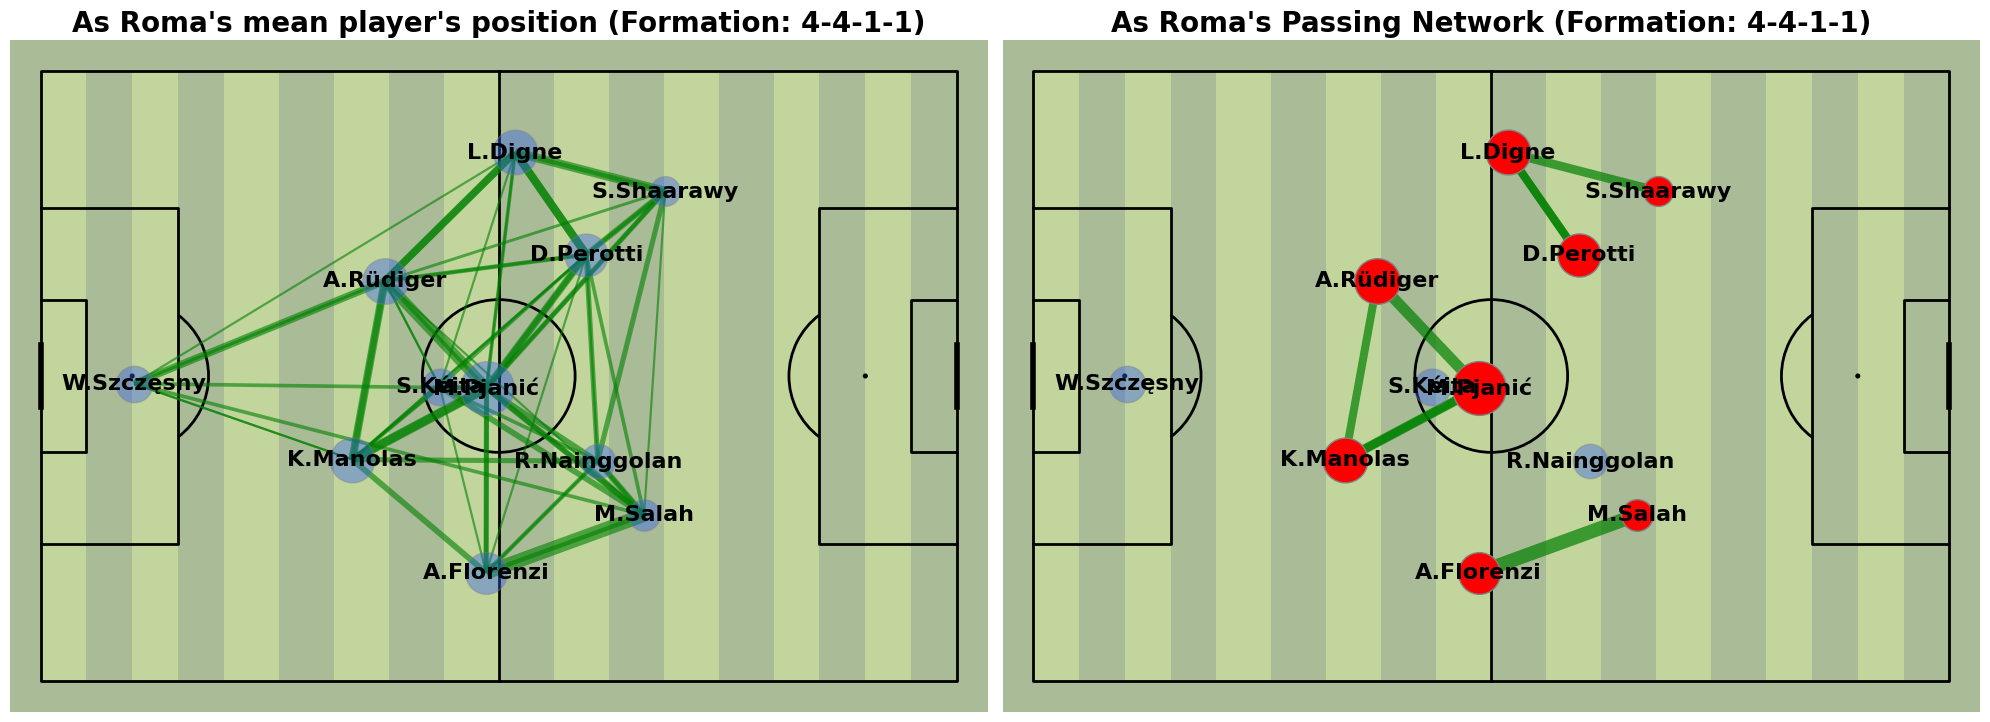

In [11]:

pitch = Pitch(line_color="black", pitch_color="#aabb97", stripe_color="#c2d59d", stripe=True)

fig, axs = plt.subplots(figsize=(20, 14), nrows=1, ncols=2)
axs = axs.flatten()

# prima parte del grafico (Posizione media dei giocatori)
ax1 = axs[0]
pitch.draw(ax=ax1)

# giocatori
for i, row in scatter_df.iterrows():
    if row.is_starter:
        pitch.scatter(row.x, row.y, s=row.marker_size, color="#2f5fed", edgecolors="grey", linewidth=1, alpha=0.4, ax=ax1, zorder=3)
        short_name = row.player_name.split()[0][0] + "." + row.player_name.split()[-1]
        pitch.annotate(short_name, xy=(row.x, row.y), c="black", va="center", ha="center", weight="bold", size=16, ax=ax1, zorder=4)

# linee tra i giocatori
for i, row in linesAll_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]

    if player1 != "" and player2 != "" and player1 in titolari and player2 in titolari:

        # estrai le coordinate per player1 e player2
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]["x"].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]["y"].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]["x"].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]["y"].iloc[0]

        # numero di passaggi tra i due giocatori
        num_passes = row["pass_count"]

        # adatta la larghezza della linea in base al numero di passaggi
        line_width = (num_passes / lines_df["pass_count"].max() * 10)

        # Disegnare la linea tra i due giocatori
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=0.6, lw=line_width, zorder=2, color="green", ax=ax1)

# titolo del primo grafico
ax1.set_title(f"As Roma's mean player's position (Formation: {modulo})", fontsize=20, fontweight="bold")

# seconda parte del grafico (Rete di passaggi)
ax2 = axs[1]
pitch.draw(ax=ax2)

# focus sulle coppie di giocatori con 10 o più passaggi intercambiati
linesTop_df = lines_df[lines_df["pass_count"]>10]

# giocatori
for i, row in scatter_df.iterrows():
    if row.is_starter:
        # controllo se il giocatore soddisfa la condizione >10
        if not any(linesTop_df["pair_key"].str.contains(row.player_name)):
            color = "#2f5fed"  # colore blu di default se non soddisfa la condizione
            a = 0.4
        else:
            color = "red"  # Colore rosso altrimenti
            a = 1
        
        pitch.scatter(row.x, row.y, s=row.marker_size, color=color, edgecolors="grey", linewidth=1, alpha=a, ax=ax2, zorder=3)
        short_name = row.player_name.split()[0][0] + "." + row.player_name.split()[-1]
        pitch.annotate(short_name, xy=(row.x, row.y), c="black", va="center", ha="center", weight="bold", size=16, ax=ax2, zorder=4)

# linee
for i, row in linesTop_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]

    if player1 != "" and player2 != "" and player1 in titolari and player2 in titolari:
        
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]["x"].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]["y"].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]["x"].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]["y"].iloc[0]
        num_passes = row["pass_count"]
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=0.7, lw=line_width, zorder=2, color="green", ax=ax2)

# titolo del secondo grafico
ax2.set_title(f"As Roma's Passing Network (Formation: {modulo})", fontsize=20, fontweight="bold")
plt.tight_layout()
plt.show()